<a href="https://colab.research.google.com/github/Galib2018/Deep-learning/blob/main/cnn_cifar10v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
 !pip install tensorflow-gpu

     |████████████████████████████████| 454.3MB 37kB/s 


In [2]:
import tensorflow as tf
tf.__version__

'2.5.0'

In [3]:
 !nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [ ]:
import keras
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.utils import np_utils
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization, Conv2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint
from keras import regularizers, optimizers

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 

#### CIFAR-10 dataset has 50,000 trainin images & 10,000 test images. Futher we divide traing dataset into 45,000 for taining and 5,000 for vlidation.

#### Preparing and split the dataset into training, validation and test set

In [ ]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

170508288/170498071 [==============================] - 2s 0us/step


In [ ]:
classes = ['aeroplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [ ]:
y_train_ary=y_train.reshape(-1,)
y_train_ary[0:10]

y_test_ary=y_test.reshape(-1,)

array([6, 9, 9, 4, 1, 1, 2, 7, 8, 3], dtype=uint8)

Text(0.5, 0, 'frog')

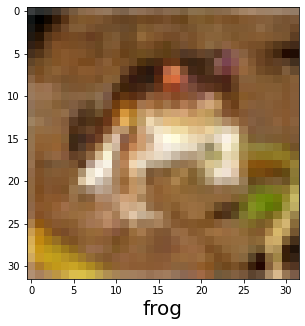

In [ ]:
plt.figure(figsize=(20,5))
plt.imshow(np.squeeze(x_train[0]))
plt.xlabel(classes[y_train_ary[0]], fontsize=20)

Ploting the training images (10 samples)

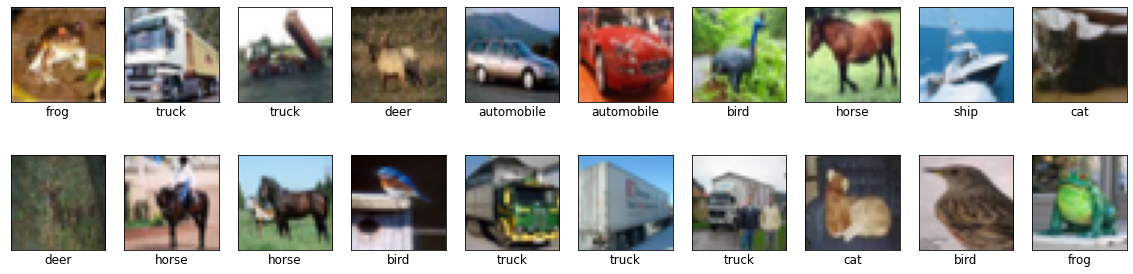

In [ ]:
def plot_fig(x, y_org, y_pred, samp):
  fig = plt.figure(figsize=(20,5))
  for i in range(samp):
    ax = fig.add_subplot(2, 10, i+1, xticks=[], yticks=[])
    ax.imshow(x[i])
    ax.set_title(classes[y_org[i]], fontsize=12)
    ax.set_xlabel(classes[y_pred[i]], fontsize=12)


plot_fig(x_train, y_train_ary, y_train_ary, samp=20)   


In [ ]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

(x_train, x_valid) = x_train[5000:], x_train[:5000]
(y_train, y_valid) = y_train[5000:], y_train[:5000]

In [ ]:
# lets print the shape of x_train, x_valid and x_test
print('Training samples:', x_train.shape)
print('validaton samples:', x_valid.shape)
print('test samples:', x_test.shape)
# format of the tuple is as: (number of instances, width, hight, channels)

Training samples: (45000, 32, 32, 3)
validaton samples: (5000, 32, 32, 3)
test samples: (10000, 32, 32, 3)


In [ ]:
y_train[:5]

array([[6],
       [7],
       [9],
       [0],
       [5]], dtype=uint8)

#### Normalizing the data by substrating the mean and standard deviation from each data point 

In [ ]:
mean = np.mean(x_train, axis=(0, 1, 2, 3))
std = np.std(x_train, axis=(0, 1, 2, 3))
x_train = (x_train-mean)/(std+1e-7)
x_valid = (x_valid-mean)/(std+1e-7)
x_test = (x_test-mean)/(std+1e-7)

#### Labeling with One-hot encoding 

In [ ]:
num_classes = 10
y_train = np_utils.to_categorical(y_train, num_classes)
y_valid = np_utils.to_categorical(y_valid, num_classes)
y_test = np_utils.to_categorical(y_test, num_classes)

In [ ]:
y_train[:10]

array([[0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]], dtype=float32)

#### Regulization technique: Data augmentation to avoid overfitting 

In [ ]:
datagen = ImageDataGenerator(rotation_range=15, width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True, 
                              vertical_flip=False)
datagen.fit(x_train)


#### Building model architecture

In this model we used six convlution layers and one fully connected (FC) layer. The considered Kernel size and pooling size are 3  ×  3 and 2  ×  2 respectively. "ReLu" activation function used in CNN hidden layers and "Softmax" is the out classification layer. We also included "droput" layer to aovid overfitting during the ttraing instances.

In [ ]:
# Declariration of Hyperparametrs:
filters= 32
weight_decay = 1e-4  # L2 regulation hyperparameter(\lamda)
# Creates a sequential model (a linear stack of layers)
model = Sequential()

In [ ]:
# CONV1
model.add(Conv2D(filters, kernel_size=3, padding='same', kernel_regularizer=regularizers.l2(weight_decay),
                input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(BatchNormalization())

# CONV2
model.add(Conv2D(filters, kernel_size=3, padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(BatchNormalization())

# POOL + Dropout
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))   # Dropout layer with 20% probability

# CONV3
model.add(Conv2D(filters*2, kernel_size=3, padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(BatchNormalization())

# CONV4
model.add(Conv2D(filters*2, kernel_size=3, padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(BatchNormalization()) 

# POOL + Dropout
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.3))

# CONV5
model.add(Conv2D(filters*4, kernel_size=3, padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(BatchNormalization())

# CONV6
model.add(Conv2D(filters*4, kernel_size=3, padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(BatchNormalization())

# POOL + Dropout
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

# FC7
model.add(Flatten())          # Flattens the feature map into 1D feature vector
model.add(Dense(10, activation='softmax'))          # 10 hidden units because the dataset has 10 class labels.
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
activation (Activation)      (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0

#### Training the above model 
Here we consodered loss as cross-entropy which is suitable for multiple classification problem. The optimizer algorithm Adam is used to calculate the loss. 

In [ ]:
batch_size = 128   # Mini-batch size
epochs = 10       # Number of tranining interations 
checkpointer = ModelCheckpoint(filepath='model.100epochs.hdf5', verbose=1, save_best_only=True)
optimizer = keras.optimizers.RMSprop(learning_rate=0.0003, decay=1e-6)

model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

history = model.fit(datagen.flow(x_train, y_train, batch_size=batch_size), callbacks=[checkpointer],
                             steps_per_epoch=x_train.shape[0] // batch_size, epochs=epochs, verbose=2,
                             validation_data=(x_test, y_test))

Epoch 1/10
351/351 - 332s - loss: 2.2612 - accuracy: 0.3397 - val_loss: 1.7283 - val_accuracy: 0.3763

Epoch 00001: val_loss improved from inf to 1.72831, saving model to model.100epochs.hdf5
Epoch 2/10
351/351 - 314s - loss: 1.6577 - accuracy: 0.4663 - val_loss: 1.3899 - val_accuracy: 0.5477

Epoch 00002: val_loss improved from 1.72831 to 1.38989, saving model to model.100epochs.hdf5
Epoch 3/10
351/351 - 315s - loss: 1.4394 - accuracy: 0.5328 - val_loss: 1.2434 - val_accuracy: 0.5983

Epoch 00003: val_loss improved from 1.38989 to 1.24339, saving model to model.100epochs.hdf5
Epoch 4/10
351/351 - 311s - loss: 1.3000 - accuracy: 0.5766 - val_loss: 1.2250 - val_accuracy: 0.6086

Epoch 00004: val_loss improved from 1.24339 to 1.22505, saving model to model.100epochs.hdf5
Epoch 5/10
351/351 - 309s - loss: 1.1806 - accuracy: 0.6139 - val_loss: 1.1259 - val_accuracy: 0.6335

Epoch 00005: val_loss improved from 1.22505 to 1.12593, saving model to model.100epochs.hdf5
Epoch 6/10
351/351 - 308

In [ ]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

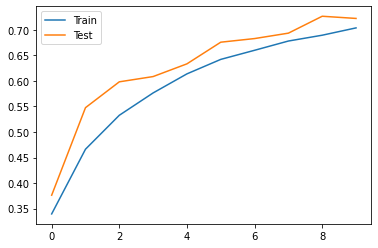

In [ ]:
# plot learning curves
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Test')
plt.legend()
plt.show()

Model Evaluation

In [ ]:
model.evaluate(x_test, y_test)

313/313 [==============================] - 16s 52ms/step - loss: 0.8834 - accuracy: 0.7224


[0.8833564519882202, 0.7224000096321106]

Loss curves 


In [ ]:
plt.figure(figsize[8,6])
plt.plot(history.history['loss'], 'black', linewidth=3.0)
plt.plot(history.history['val_loss'], 'black', ls = '--', linewidth=3.0)
plt.legend(['Training loss', 'Validation loss'], fontsize=18)
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.title('Loss Curves', fontsize=16)

Ploting the test samples 

In [ ]:
plot_fig(x_test, y_test_ary, sam=10)

Prediction of test samples 

In [ ]:
y_pred = model.predict(x_test)
y_pred[:5]

In [ ]:
y_pred_classes = [np.argmax(element) for element in y_pred]
y_pred_classes[:5]

plot_fig(x_test, y_test_ary, y_pred_classes, samp=10)